<a href="https://colab.research.google.com/github/mvince33/Coding-Dojo/blob/main/week07/Cross_Validation_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-Validation in Python



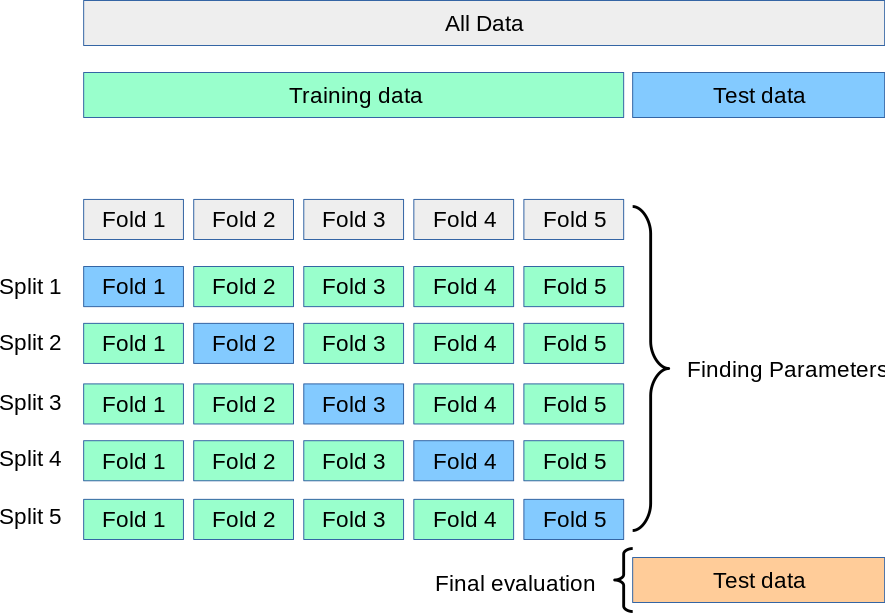

Image Source: [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

## Notebook Steps:
This notebook will demonstrate the following steps:
1. Import Needed Libraries
2. Import and Prepare Data
3. Create a Pipeline to Scale Data and Model Using K-Nearest Neighbors
4. Evaluate a Model using Cross-validation.
5. Hyperparameter Tune a Model using Cross-Validation.

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

# Data Preparation
We will use the famous Iris dataset.  We will attempt to use measurements of the flower to determine which type of flower each sample is.

In [2]:
# Load Iris Dataset

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target
X.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

In [3]:
classes, counts = np.unique(y, return_counts=True)

for n in range(len(classes)):
  print(f'Class {classes[n]} has {counts[n]} members')

Class 0 has 50 members
Class 1 has 50 members
Class 2 has 50 members


The classes are balanced.

In [4]:
# Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

print('Train Size', X_train.shape[0])
print('Test Size', X_test.shape[0])

Train Size 112
Test Size 38


## Pipeline

In [5]:
# Create a preprocessing and modeling pipeline to scale the data and prevent data leakage.

knn = KNeighborsClassifier()
scaler = StandardScaler()

knn_pipe = make_pipeline(scaler, knn)

## Cross Validation

### Preventing Data Leakage:

When we use the pipeline for the cross-validation, the data gets re-scaled for each fold.  This prevents data leakage between each fold.  If we did not use a pipeline for the scaling, then the we would have to scale all of the data before we cross-validated the model.  This would cause data leakage between the testing and training splits within the cross-validation function.

### Change Number of Folds
We will set the number of folds to 5 using the argument `cv=5`.  We could change this to any number we wanted.

In [6]:
# Use cross-validation to create an array of scores for each fold

scores = cross_val_score(knn_pipe, X_train, y_train, cv=5)

print(f'Accuracy scores for each fold are: {scores.round(2)}')
print(f'Average accuracy across folds is {np.mean(scores)}')

Accuracy scores for each fold are: [0.96 0.87 1.   1.   0.95]
Average accuracy across folds is 0.9561264822134387


# Results
You can see that each fold has significantly different scores!  They range from 82% to 100%!  If we had just used one of these folds for our model evaluation we may have been surprised at the performance of the model on new data.

We can average the scores to get one number for comparing multiple models.

# Tuning Hyperparameters using Cross-Validation

Notice that we haven't used our original test set yet!  We can compare the average cross-validation scores across many values of k in our KNN model, and then score the best one on the test set that we are holding out.  This prevents us from just choosing the value of k that works best for the hold-out set, but may not work best for new data.

In [7]:
# Create a range of odd integer from 1 to 19 values for the k number of neighbors

ks = range(1,20, 2)
list(ks)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

In [8]:
# loop through values of K

scores = []

for k in ks:
  knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
  scores.append(cross_val_score(knn_pipe, X_train, y_train))

scores

[array([0.95652174, 0.86956522, 0.95454545, 0.95454545, 1.        ]),
 array([0.95652174, 0.91304348, 0.95454545, 1.        , 1.        ]),
 array([0.95652174, 0.86956522, 1.        , 1.        , 0.95454545]),
 array([0.95652174, 0.91304348, 1.        , 1.        , 1.        ]),
 array([0.95652174, 0.95652174, 1.        , 1.        , 1.        ]),
 array([0.95652174, 0.91304348, 1.        , 1.        , 1.        ]),
 array([0.95652174, 0.86956522, 0.95454545, 1.        , 1.        ]),
 array([0.95652174, 0.86956522, 0.95454545, 1.        , 1.        ]),
 array([0.95652174, 0.86956522, 0.95454545, 1.        , 1.        ]),
 array([0.95652174, 0.86956522, 0.95454545, 1.        , 1.        ])]

Different values for k perform better on different folds of the data.  Let's average the folds for each value of K to make them easier to compare.

`enumerate()` returns both the index and the value in a collection while iterating over it.

In [9]:
for index, k in enumerate(ks):
  mean_score = np.mean(scores[index])
  print(f'Score for n_neighbors = {k} is {mean_score}')

Score for n_neighbors = 1 is 0.9470355731225297
Score for n_neighbors = 3 is 0.9648221343873518
Score for n_neighbors = 5 is 0.9561264822134387
Score for n_neighbors = 7 is 0.9739130434782609
Score for n_neighbors = 9 is 0.9826086956521738
Score for n_neighbors = 11 is 0.9739130434782609
Score for n_neighbors = 13 is 0.9561264822134387
Score for n_neighbors = 15 is 0.9561264822134387
Score for n_neighbors = 17 is 0.9561264822134387
Score for n_neighbors = 19 is 0.9561264822134387


It looks like the average cross-validation score for n_neighbors = 9 gives the best score.

# Evaluate the final model on the hold-out test set.

In [10]:
# Create a final model and final pipeline
final_model = KNeighborsClassifier(n_neighbors=9)
final_pipe = make_pipeline(StandardScaler(), final_model)
final_pipe.fit(X_train, y_train)

# Evaluate the accuracy of the final pipeline model on the test set.
final_pipe.score(X_test, y_test)

0.9473684210526315

Our final model scores are lower than our cross-validated models, and lower than a model that was tuned to perform well specifically on the hold-out dataset.  This is actually a good thing! While `n_neighbors=9` might not be the hyperparameter that works best on this particular test set, we can be more confident that our model will perform at closer to that well on new, unseen data.